# Deep Learning Workshop 1 - Batch Normalization for Fully-Connected Deep Networks (FCDNs)
2019/09/11

[ Reference ]
+ Rui Shu, "**TENSORFLOW GUIDE: BATCH NORMALIZATION**", 2016/12/26. http://ruishu.io/2016/12/27/batchnorm/
    + Github code: https://github.com/RuiShu/micro-projects/blob/master/tf-batchnorm/batchnorm_guide.ipynb
+ Antoine Labatie, "**It’s Necessary to Combine Batch Norm and Skip Connections**", Towards Data Science, 2019/09/01. https://towardsdatascience.com/its-necessary-to-combine-batch-norm-and-skip-connections-e92210ca04da
+ Federico Peccia, "**Batch normalization: theory and how to use it with Tensorflow**", , Towards Data Science, 2018/09/16. https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

------------------------
## **`tf.contrib.layers.batch_norm()`**

+ https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

>+ It can be used as a **normalizer function** for `tf.contrib.layers.conv2d` and `tf.contrib.layers.fully_connected`. 
+ The normalization is over all but the last dimension if `data_format` is **NHWC** and all but the second dimension if `data_format` is **NCHW**. 
    + **NHWC** : (Samples, Height, Width, Channels)
    + **NCHW** : (Samples, Channels, Height, Width)
> + In case of a 2D tensor this corresponds to the batch dimension, while in case of a 4D tensor this corresponds to the batch and space dimensions.
------------------------

- [< Case Study > : Batch_Norm for FCDNs](#BNforFCDNs)
- [< Exercise > : Batch_Norm for Both CNNs & FCDNs](#BNforBoth)

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# for the old-version usage of TensorFlow, such as tensorflow.examples.tutorials.mnist
old_v = tf.logging.get_verbosity()          
tf.logging.set_verbosity(tf.logging.ERROR) 

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### Input MNIST dataset 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(" mnist.train.images.shape :\t ", mnist.train.images.shape)
print(" mnist.train.labels.shape :\t ", mnist.train.labels.shape)
print(" mnist.validation.images.shape : ", mnist.validation.images.shape)
print(" mnist.validation.labels.shape : ", mnist.validation.labels.shape)
print(" mnist.test.images.shape :\t ", mnist.test.images.shape)
print(" mnist.test.labels.shape :\t ", mnist.test.labels.shape)

mnist.test.labels[0]

 mnist.train.images.shape :	  (55000, 784)
 mnist.train.labels.shape :	  (55000, 10)
 mnist.validation.images.shape :  (5000, 784)
 mnist.validation.labels.shape :  (5000, 10)
 mnist.test.images.shape :	  (10000, 784)
 mnist.test.labels.shape :	  (10000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

--------------------------------------
<a id='BNforFCDNs'></a>
## < Case Study > : Batch_Norm for FCDNs


> + **[NOTE]: the `phase` term. **
    + useed as a **placeholder for a boolean** which we will insert into ``feed_dict`. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 

In [4]:
def train_test():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # --------------------------------------
    # Launch the computation graph...
    # --------------------------------------
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    batch_size = 100
    iterep = 550
    epochs = 30
    for i in range(iterep * epochs):
        x_train, y_train = mnist.train.next_batch(batch_size)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.validation.images,
                                    'y:0': mnist.validation.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print(history[-1])
            
    print("\n Computing the test accuracy ... ", end = " ")
    
    ##  ------------------------------------------------------------------
    ##  Test datasets...
    ##  ------------------------------------------------------------------
    test_loss = sess.run(loss, feed_dict={'x:0': mnist.test.images,
                                          'y:0': mnist.test.labels,
                                          'phase:0': 0})
    test_accu = sess.run(accuracy, feed_dict={'x:0': mnist.test.images,
                                              'y:0': mnist.test.labels,
                                              'phase:0': 0})
    print(" Done !!! ")
    
    return history, test_accu, test_loss

## < Case 1 > : No batch normalization

In [5]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [6]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [7]:
history, test_accu, test_loss = train_test()

[1.0, 0.56948286, 0.85914546, 0.5460789, 0.8672]
[2.0, 0.3990712, 0.8882909, 0.38020584, 0.8968]
[3.0, 0.34536183, 0.902, 0.32940552, 0.9098]
[4.0, 0.31385082, 0.90965456, 0.2985422, 0.9178]
[5.0, 0.2946377, 0.9135818, 0.27967197, 0.9224]
[6.0, 0.274294, 0.9211091, 0.2607507, 0.9288]
[7.0, 0.26011416, 0.9248545, 0.2485116, 0.9306]
[8.0, 0.2462821, 0.92956364, 0.23528725, 0.9338]
[9.0, 0.23556133, 0.9326, 0.22447944, 0.9372]
[10.0, 0.22727837, 0.93430907, 0.21688579, 0.9384]
[11.0, 0.21667795, 0.9387818, 0.20820801, 0.942]
[12.0, 0.20843327, 0.9396545, 0.20019694, 0.9428]
[13.0, 0.19993174, 0.94307274, 0.19254984, 0.9466]
[14.0, 0.19153447, 0.9450727, 0.18519872, 0.9488]
[15.0, 0.18571065, 0.9468909, 0.18037364, 0.951]
[16.0, 0.17830107, 0.94845456, 0.17332813, 0.9516]
[17.0, 0.17309855, 0.9504727, 0.1697473, 0.953]
[18.0, 0.16730319, 0.9516, 0.16421837, 0.9556]
[19.0, 0.16285728, 0.95287275, 0.1594349, 0.9552]
[20.0, 0.15739536, 0.9543273, 0.15610866, 0.9576]
[21.0, 0.15278651, 0.95625

In [8]:
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 [ Test  Accuracy ] : 0.9609000086784363
 [ Test Loss Score ] : 0.13149605691432953


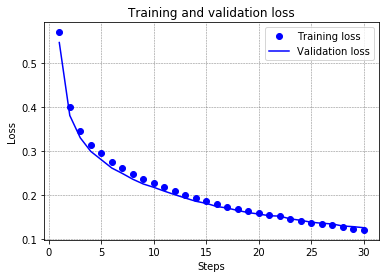

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

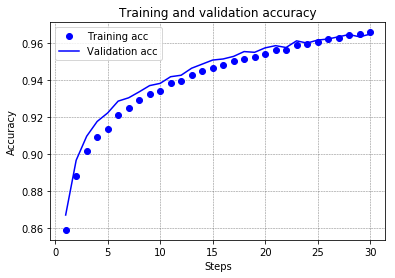

In [10]:
plt.clf()   # clear figure

plt.plot(steps, [history[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 2 > : Standard batch normalization
+ Batch normalization would be to simply use the `tf.contrib.layers.batch_norm layer`.
+ One thing that might stand out is the `phase` term. 
    + We are going to use as a **placeholder for a boolean** which we will insert into feed_dict. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 
    
    
+ Recall that batch normalization has distinct behaviors during training verus test time:
> + Training
    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.
 + Testing
    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [11]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        
        # Batch normalization would be to simply use the tf.contrib.layers.batch_norm layer.
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training = phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [12]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# FCDNetwork with 2 hidden layers...
h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [13]:
history_bn, test_accu_bn, test_loss_bn = train_test()

[1.0, 0.38118663, 0.9044727, 1.1314288, 0.8788]
[2.0, 0.26975784, 0.9290364, 0.63706183, 0.927]
[3.0, 0.21947885, 0.9416909, 0.37758964, 0.942]
[4.0, 0.18855226, 0.9494, 0.2622572, 0.9486]
[5.0, 0.16695158, 0.9548909, 0.20740332, 0.9516]
[6.0, 0.15013546, 0.9592, 0.17912255, 0.9558]
[7.0, 0.13631724, 0.9629091, 0.15985698, 0.9574]
[8.0, 0.12493216, 0.9660909, 0.14786366, 0.96]
[9.0, 0.115378976, 0.9688727, 0.13980664, 0.962]
[10.0, 0.106848724, 0.97136366, 0.13326487, 0.963]
[11.0, 0.09948726, 0.97385454, 0.12705545, 0.9648]
[12.0, 0.09309396, 0.9757091, 0.123387955, 0.9654]
[13.0, 0.08727306, 0.97752726, 0.11665487, 0.9672]
[14.0, 0.081937365, 0.97894543, 0.11469628, 0.9668]
[15.0, 0.07711262, 0.98014545, 0.109861374, 0.9682]
[16.0, 0.07289235, 0.9811091, 0.107100904, 0.9686]
[17.0, 0.06888797, 0.9821636, 0.104383826, 0.9692]
[18.0, 0.06501142, 0.98367274, 0.102080226, 0.9696]
[19.0, 0.061529722, 0.9842727, 0.099990025, 0.9696]
[20.0, 0.058188103, 0.98554546, 0.099034086, 0.9698]
[21.

In [14]:
print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.974399983882904
 [ Test Loss Score ] : 0.08047136664390564

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9609000086784363
 [ Test Loss Score ] : 0.13149605691432953


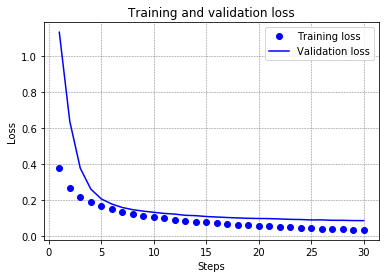

In [15]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history_bn[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

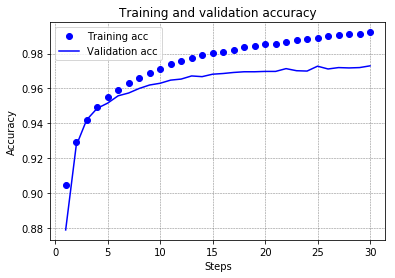

In [16]:
plt.clf()   # clear figure

plt.plot(steps, [history_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history_bn[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 3 > : Post-activation batch normalization

In [17]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        
        ##  Post-activation batch normalization...
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [18]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu_batch(x, phase,'layer1')
h2 = dense_relu_batch(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [19]:
history_post_bn, test_accu_post_bn, test_loss_post_bn = train_test()

[1.0, 0.2829858, 0.9209273, 1.2845974, 0.8138]
[2.0, 0.20700224, 0.94223636, 0.8121468, 0.9032]
[3.0, 0.16949522, 0.9523636, 0.4839947, 0.9366]
[4.0, 0.14483324, 0.95936364, 0.29570454, 0.9498]
[5.0, 0.1273487, 0.96483636, 0.20002446, 0.9558]
[6.0, 0.11350574, 0.9697818, 0.16011329, 0.9616]
[7.0, 0.10241012, 0.9729091, 0.13453278, 0.9664]
[8.0, 0.09341617, 0.97483635, 0.12017174, 0.9694]
[9.0, 0.0855612, 0.97752726, 0.11361568, 0.9702]
[10.0, 0.07851132, 0.9800364, 0.10599602, 0.9714]
[11.0, 0.07255619, 0.98154545, 0.100621, 0.9718]
[12.0, 0.067436524, 0.98325455, 0.09700604, 0.9718]
[13.0, 0.06262488, 0.9841818, 0.0942079, 0.9752]
[14.0, 0.058487248, 0.9857818, 0.09195694, 0.9748]
[15.0, 0.054697555, 0.9869091, 0.09008959, 0.975]
[16.0, 0.051042285, 0.98807275, 0.090047985, 0.9734]
[17.0, 0.04796708, 0.9888727, 0.08713581, 0.9754]
[18.0, 0.04469363, 0.9897818, 0.086369425, 0.9748]
[19.0, 0.04211639, 0.99056363, 0.087092504, 0.9736]
[20.0, 0.03965029, 0.99094546, 0.08513391, 0.975]
[21

In [20]:
print(" <<< Post-activation Batch Normalization >>> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_post_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_post_bn))

print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 <<< Post-activation Batch Normalization >>> :
 [ Test  Accuracy ] : 0.9713000059127808
 [ Test Loss Score ] : 0.08808525651693344
 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.974399983882904
 [ Test Loss Score ] : 0.08047136664390564

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9609000086784363
 [ Test Loss Score ] : 0.13149605691432953


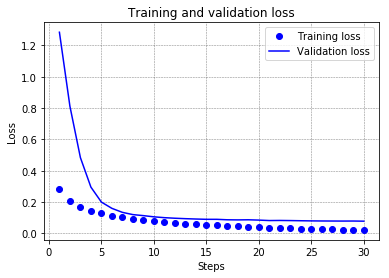

In [21]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_post_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history_post_bn[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

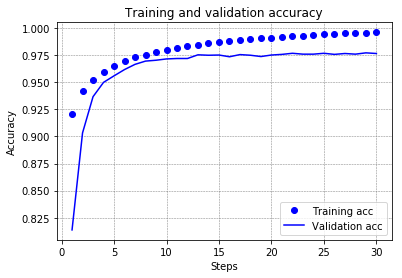

In [22]:
plt.clf()   # clear figure

plt.plot(steps, [history_post_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history_post_bn[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## Evaluation

In [23]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [24]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

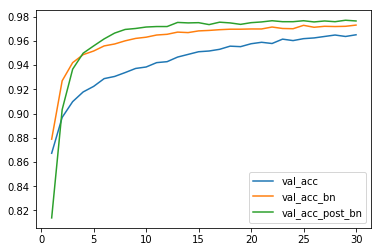

In [25]:
plt.plot(history[:, 0], history[:, -1], label='val_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='val_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='val_acc_post_bn')
plt.legend()
plt.show()

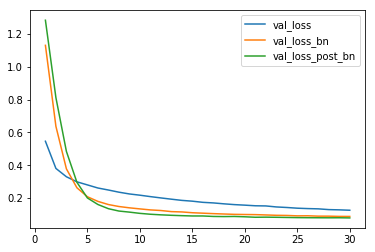

In [26]:
plt.clf()   # clear figure

plt.plot(history[:, 0], history[:, -2], label='val_loss')
plt.plot(history_bn[:, 0], history_bn[:, -2], label='val_loss_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -2], label='val_loss_post_bn')
plt.legend()
plt.show()

+ ### As you can see, batch normalization really does help with training (not always, but it certainly did in this simple example).

--------------------------------------
<a id='BNforBoth'></a>
## < Exercise > : Batch_Norm for Both CNNs & FCDNs 

[ REFERENCE ] :
+ dhwajraj, "How I can apply batch normalization?", 2016/12/07. https://github.com/dennybritz/cnn-text-classification-tf/issues/29
+ `tf.contrib.layers.conv2d`:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d

> conv1 = `tf.contrib.layers.conv2d(...,
                                  normalizer_fn = tf.contrib.layers.batch_norm, 
                                  ...)`

> conv_out = `tf.nn.relu(conv1)`

## [ Problem ]: 
> 1. Please modify the Case-Study TensorFlow code above for solving **CNNs**, which includes "Convolution Layers" & "MaxPooling Layers", as following:
    + **Conv Layer 1**
    + **MaxPool Layer 1**
    + **Conv Layer 2**
    + **MaxPool Layer 2**
    + **Hidden Layer** 
    + **Hidden Layer** 
    + **Output Layer**
    
> 2. Using Batch Normalization by applying `tf.contrib.layers.batch_norm()` to `tf.contrib.layers.conv2d()`. 

> 3. And then, compare the results with those in **Case Study** above.